# Integrating Product Design and Supply Chain Design

## Import Packages

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum as qsum
import pandas as pd
from pandas import DataFrame, read_csv
import random
import math

import sys
sys.path.append('../')
import saedfsc;

## Parameters

In [12]:
numAssemblyOptions = 2
numSuppliersPerPart = 2

In [13]:
components = [1, 2, 3]
componentsForSubsystems = {}
subsystemsForComponents = {}
assembliesStructure = {4 : [1,2], 
                       3 : []}
assemblyNodes = list(assembliesStructure.keys())
finalNodes = [5]
allNodes = components + assemblyNodes + finalNodes
nonComponentNodes = assemblyNodes + finalNodes
print(components)
print(allNodes)

[1, 2, 3]
[1, 2, 3, 4, 3, 5]


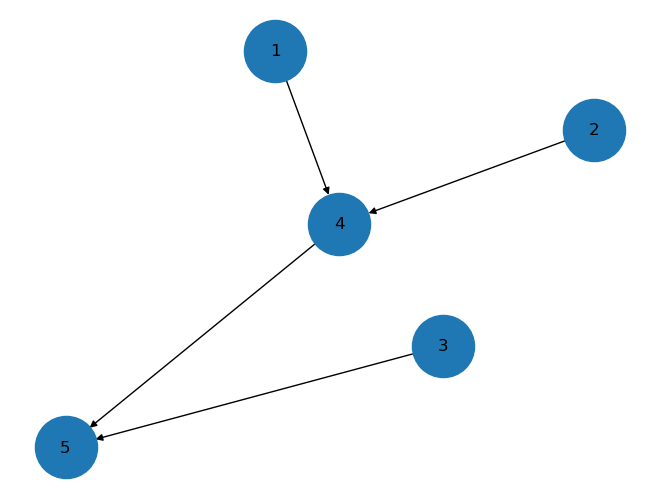

In [25]:
G = nx.DiGraph()

numNodes = len(components) + len(assemblyNodes) + len(finalNodes)

np.random.seed(0)
# stageCostsList = np.random.randint(1, 10, numNodes)
# processTimesList = np.random.randint(1, 10, numNodes)
maxServiceTimeOutList = 20*np.ones(numNodes)
maxServiceTimeOutList[numNodes-1] = 0

for n in allNodes:
    time = np.random.randint(1, 5)
    if n in finalNodes:
        maxTime = 0
    else:
        maxTime = 100
    G.add_node(n, process_time=time, 
               max_service_time_out=maxTime,
               stage_cost=np.random.randint(1, 5))

for n in assemblyNodes:
    for component in assembliesStructure[n]:
        G.add_edge(component, n)

for n in assemblyNodes:
    for n2 in finalNodes:
        G.add_edge(n, n2)

maxServiceTimeOut = nx.get_node_attributes(G, 'max_service_time_out')
processTimesDict = nx.get_node_attributes(G, 'process_time')
costDict = nx.get_node_attributes(G, 'stage_cost')
maxServiceTimeOut = nx.get_node_attributes(G, 'max_service_time_out')

nx.draw(G, with_labels=True, node_size=2000)
plt.show()

In [26]:
# G = nx.DiGraph()

# numProcureNodes = 2
# numAssemblyNodes = 1
# numNodes = numProcureNodes + numAssemblyNodes + 1

# procureNodes = list(range(numProcureNodes))
# assemblyNodes = list(range(numProcureNodes, 
#                            numProcureNodes + numAssemblyNodes))
# finalNodes = [numNodes - 1]

# numNodes = len(components) + len(assemblyNodes) + len(finalNodes)

# np.random.seed(0)
# stageCostsList = np.random.randint(1, 10, numNodes)
# processTimesList = np.random.randint(1, 10, numNodes)
# maxServiceTimeOutList = 20*np.ones(numNodes)
# maxServiceTimeOutList[numNodes-1] = 0

# for n in allNodes:
#     time = np.random.randint(1, 10)
#     G.add_node(n, process_time=time, 
#                max_service_time_out=2*time,
#                stage_cost=np.random.randint(1, 10))

# for n in assemblyNodes:
#     for component in assembliesStructure[n]:
#         G.add_edge(component, n)

# for n in assemblyNodes:
#     for n2 in finalNodes:
#         G.add_edge(n, n2)

# print(procureNodes, assemblyNodes, finalNode)
# numOptions = 2

# np.random.seed(0)

# maxServiceTimeOut = 20

# processTimes = np.random.randint(1,5, numNodes)
# costAdded = np.random.randint(1,5, numNodes)

# G.add_node(finalNode, process_time=processTimes[finalNode], 
#             max_service_time_out=0, cost = costAdded[finalNode])

# for n in assemblyNodes:
#     G.add_node(n, process_time=processTimes[n], 
#                max_service_time_out=20, cost = costAdded[n])
#     G.add_edge(n, finalNode)

# for n in procureNodes:
#     G.add_node(n, process_time=processTimes[n], 
#                max_service_time_out=20, cost = costAdded[n])
#     G.add_edge(n, finalNode)

# processTimesDict = nx.get_node_attributes(G, 'process_time')
# costDict = nx.get_node_attributes(G, 'cost')
# maxServiceTimeOut = nx.get_node_attributes(G, 'max_service_time_out')

# pred = {2 : [1,0]}
# nx.draw(G, with_labels=True)
# plt.show()

In [27]:
safetyFactor = 1.645
sigma = 3
holdingCostRate = 0.2

In [28]:

maxReplenishmentTime = {}

for n in components:
    maxReplenishmentTime[n] = processTimesDict[n]

for n in assemblyNodes:
    maxReplenishmentTime[n] = processTimesDict[n] + max([maxReplenishmentTime[n] for n in components])

for finalNode in finalNodes:
    maxReplenishmentTime[finalNode] = processTimesDict[finalNode] + max([maxReplenishmentTime[n] for n in assemblyNodes])

cumCost = {}

for n in components:
    cumCost[n] = costDict[n]

for n in assemblyNodes:
    cumCost[n] = costDict[n] + max([cumCost[n] for n in components])

for finalNode in finalNodes:
    cumCost[finalNode] = costDict[finalNode] + sum(cumCost[n] for n in assemblyNodes)

df = pd.DataFrame({
    'Node': maxReplenishmentTime.keys(),
    'Process time': processTimesDict.values(),
    'Stage cost': costDict.values(),
    'Cumulative cost': cumCost.values(),
    'Max time': maxServiceTimeOut.values(),
    'maxReplenishmentTime': maxReplenishmentTime.values()
})
df

,Node,Process time,Stage cost,Cumulative cost,Max time,maxReplenishmentTime
0,1,1,4,4,100,1
1,2,2,1,1,100,2
2,3,2,4,8,100,4
3,4,4,4,8,100,6
4,5,2,3,19,0,8


In [31]:

def get_sIn_range_for_g_fn(node : int):
    maxVal = maxReplenishmentTime[node] - processTimesDict[node]
    return range(maxVal + 1)

def get_sOut_range_for_g_fn(node : int, sIn : int):
    maxVal = sIn + processTimesDict[node]
    if node == finalNode:
        maxVal = min(maxVal, maxServiceTimeOut[finalNode])
    return range(maxVal + 1)

def get_sOut_range(node : int, sIn : int = 0):
    #maxVal = maxReplenishmentTime[node] - processTimesDict[node]
    return range(sIn + processTimesDict[node]+ 1)

def getHoldingCost(node : int, sIn : int, sOut : int):
    return safetyFactor*sigma*holdingCostRate*cumCost[node]*np.sqrt(sIn + processTimesDict[node] - sOut)

def create_dp_graph(G : nx.DiGraph):
    nNodes = len(G.nodes())
    finalNode = 5
    dp_G = nx.DiGraph()
    dp_G.add_node('t')
    for sIn in get_sIn_range_for_g_fn(finalNode):
        for sOut in get_sOut_range_for_g_fn(finalNode, sIn):
            finalNodeTuple = (finalNode, sIn, sOut)
            dp_G.add_node(finalNodeTuple)
            dp_G.add_edge(finalNodeTuple, 't', 
                        cost = getHoldingCost(finalNode, sIn, sOut))
            for n in components:
                for sOut in get_sOut_range(n, 0):
                    nodeTuple = (n, 0, sOut)
                    dp_G.add_node(nodeTuple)
            # n = 2
            # for sOut in get_sOut_range(n, 0):
            #     nodeTuple = (n, 0, sOut)
            #     if sOut == sIn:
            #         dp_G.add_edge(nodeTuple, finalNodeTuple, 
            #                         cost = getHoldingCost(n, 0, sOut))
            # n = 1
            # for sOut in get_sOut_range(n, 0):
            #     nodeTuple = (n, 0, sOut)
            #     dp_G.add_edge('s', nodeTuple, cost = getHoldingCost(n, 0, sOut))
            #     for sOut2 in get_sOut_range(n+1, 0):
            #         if sOut == min(sOut2, maxReplenishmentTime[n]):
            #             nodeTuple2 = (n+1, 0, sOut2)
            #             dp_G.add_edge(nodeTuple, nodeTuple2, cost = getHoldingCost(n+1, 0, sOut2))
                


    return dp_G

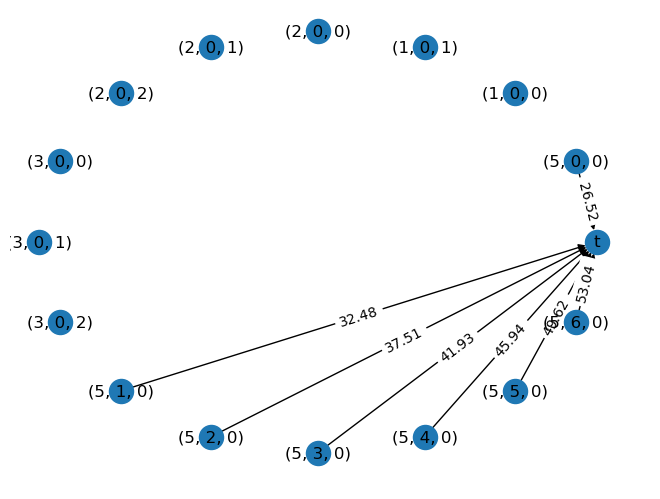

In [32]:
dp_G = create_dp_graph(G)

pos = nx.circular_layout(dp_G)
nx.draw(dp_G, pos, with_labels=True)
edge_labels = nx.get_edge_attributes(dp_G, 'cost')
edge_labels = {k: round(v, 2) for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [20]:
start_node = 's'  # replace with your start node
end_node = 't'  # replace with your end node

path = nx.shortest_path(dp_G, start_node, end_node, weight='cost')
path_length = nx.shortest_path_length(dp_G, start_node, end_node, weight='cost')
print("Total cost", path_length)
print(path)

def getServiceTimeIn(node : int, path : list):
    if node in components:
        return 0
    else:
        for sIn in range(0,max([maxReplenishmentTime[n] for n in components])+1):
            if (node, sIn, 0) in path:
                return sIn
            
def getServiceTimeOut(node : int, path : list):
    if node == finalNode:
        return 0
    else:
        for sOut in range(0,processTimesDict[node]+1):
            if (node, 0, sOut) in path:
                return sOut


df = pd.DataFrame({
    'Node': maxReplenishmentTime.keys(),
    'Process time': processTimes,
    'Stage cost': costDict.values(),
    'Cumulative cost': cumCost.values(),
    'maxReplenishmentTime': maxReplenishmentTime.values(),
    'Service time in': [getServiceTimeIn(node, path) for node in range(0,3)],
    'Service time out': [getServiceTimeOut(node, path) for node in range(0,3)],
    'Holding cost': [getHoldingCost(node, getServiceTimeIn(node, path), 
                                    getServiceTimeOut(node, path)) for node in range(0,3)]
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)
df

NodeNotFound: Either source s or target t is not in G

In [ ]:
# def isFeasibleForNode(node : int, sIn : int, sOut : int):
#     if sIn + processTimesDict[node] - sOut >= 0:
#         return True
#     else:
#         return False

# m = gp.Model("Network")

# z = m.addVar(name = "final")

# x = m.addVars([finalNode], get_sIn_range_for_g_fn(finalNode), [0], name = "x")
# y = m.addVars(procureNodes, get_sIn_range_for_g_fn(finalNode), name = "y")

# m.update()
# print(x)
# print(y)

# m.addConstrs((z <= x[finalNode, sIn, 0] for sIn in get_sIn_range_for_g_fn(finalNode)), 
#               name = "lastMin")

# m.addConstrs((x[finalNode, sIn, 0] == getHoldingCost(finalNode, sIn, 0) + qsum(y[n,sIn] for n in pred[finalNode])
#               for sIn in get_sIn_range_for_g_fn(finalNode) if isFeasibleForNode(n, 0, sIn)), 
#              name = "sum")

# for n in procureNodes:
#     for sIn in get_sIn_range_for_g_fn(finalNode):
#         if isFeasibleForNode(n, 0, sIn):
#             print(n, sIn, getHoldingCost(n, 0, sIn) )
        
# m.addConstrs((y[n, sIn] == getHoldingCost(n, 0, sIn) 
#               for sIn in get_sIn_range_for_g_fn(finalNode) 
#               for n in procureNodes if isFeasibleForNode(n, 0, sIn)))

# m.setObjective(z, GRB.MINIMIZE)
# m.optimize()

# for v in m.getVars():
#     print(v.varName, v.X)